
Working Matt Harrison's excellent plotting example (ref: [https://twitter.com/__mharrison__/status/1595447158832078853](https://twitter.com/__mharrison__/status/1595447158832078853) ) in the [data algebra](https://github.com/WinVector/data_algebra).

![](https://github.com/WinVector/data_algebra/blob/main/Examples/AutoPlot/Screenshot%202022-11-23%20at%209.33.19%20AM.png?raw=true)

Data from: http://www.fueleconomy.gov/feg/epadata/vehicles.csv.zip . Looks similar to the original data.

The recreation. Our code is a bit different, as the data is slightly different in what is marked as NaN.

In [1]:
import pandas as pd
import data_algebra
import data_algebra.SQLite
import data_algebra.test_util
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["figure.figsize"] = (12, 6)
pd.options.display.float_format = "{:,.2f}".format


In [3]:
autos = pd.read_csv(
        "vehicles.csv.gz", 
        low_memory=False)

In [4]:
# Fords city mpg by cylinders over the years
ops = (
    data_algebra.descr(
        # start with a description of the data
        autos=autos)
        .extend(
             # take cylinders missing to be zero
            {"cylinders": "cylinders.coalesce(0)"}) 
        .select_rows(
            # keep only rows without missing values in our columns of interest
            " and ".join([f"(not {v}.is_bad())" for v in["make", "year", "city08"]]) 
            # limit to Fords before 2019 
            + " and (make == 'Ford') and (year < 2019)") 
        .extend(
            # convert cylinders from float to int for better formatting
            {"cylinders": "cylinders.as_int64()"}) 
        .project(  
            # summarize data by year and cylinders
            {"city mpg": "city08.mean()"},
            group_by=["year", "cylinders"])
)

In [5]:
# apply the operations to the data
plot_frame = ops.transform(autos)

plot_frame

,year,cylinders,city mpg
0,1984,4,21.04
1,1984,6,14.24
2,1984,8,11.32
3,1985,4,22.43
4,1985,6,14.52
...,...,...,...
120,2018,0,118.00
121,2018,3,28.00
122,2018,4,22.97
123,2018,6,17.41


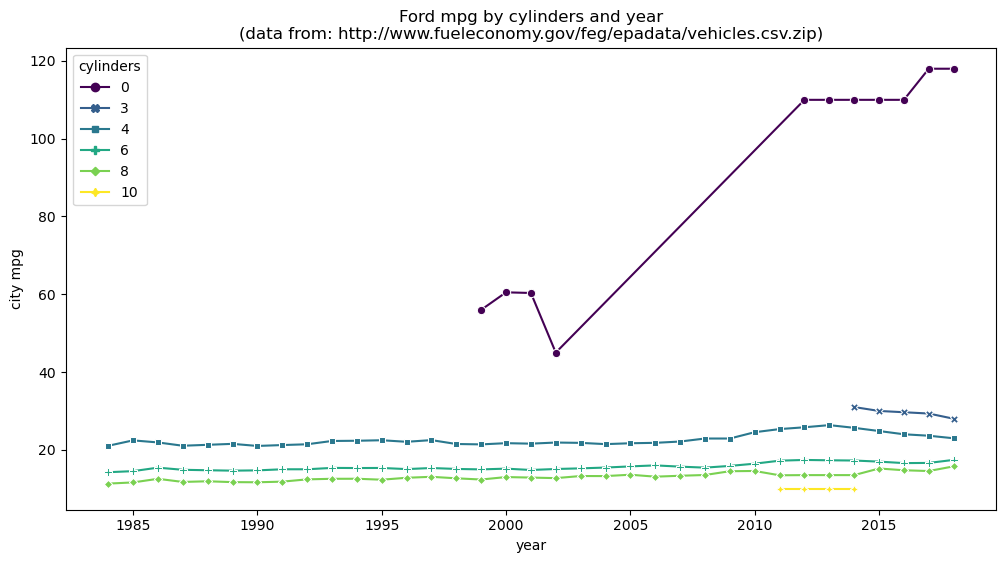

In [6]:
# make the plot
sns.lineplot(
    data=plot_frame,
    x="year",
    y="city mpg",
    hue="cylinders",
    style="cylinders",
    markers=True,
    dashes=False,
    sort=True,
    palette=sns.color_palette("viridis", as_cmap=True)
)
_ = plt.title("Ford mpg by cylinders and year\n(data from: http://www.fueleconomy.gov/feg/epadata/vehicles.csv.zip)")

Normally we could disconnect the lines by introducing explicit NA back where we have missing data. However [this isn't how the Seaborn plotting software works](https://stackoverflow.com/a/52100393/6901725).

The original plot commands, confirming the data is a bit different in what is missing or marked as NaN.

<AxesSubplot:xlabel='year'>

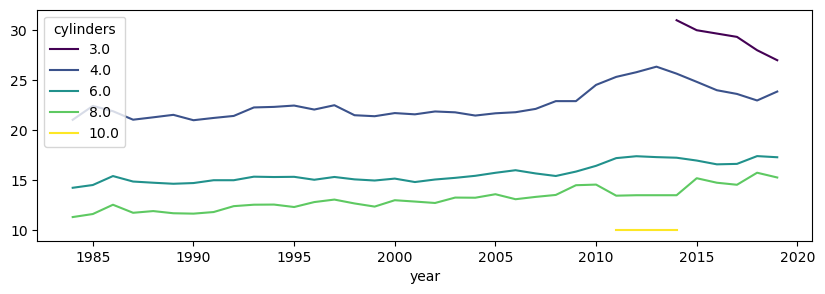

In [7]:
fix, ax = plt.subplots(figsize=(10, 3))
# Fords city mpg by cylinders over the years
(autos
    .groupby(['year', 'cylinders', 'make'], observed=True)
    .city08
    .mean()
    .unstack()  # moves inner index to column names
    .loc[:2019, 'Ford']
    .unstack()
    .dropna(axis='columns', how='all')
    .plot(cmap='viridis', ax=ax)
)

And, automatic translation to SQL

In [8]:
hdl = data_algebra.SQLite.example_handle()
hdl.insert_table(autos, table_name="autos")
res_sql = hdl.read_query(ops)
hdl.close()
res_sql

,city mpg,year,cylinders
0,21.04,1984,4
1,14.24,1984,6
2,11.32,1984,8
3,22.43,1985,4
4,14.52,1985,6
...,...,...,...
120,118.00,2018,0
121,28.00,2018,3
122,22.97,2018,4
123,17.41,2018,6


In [9]:
assert data_algebra.test_util.equivalent_frames(plot_frame, res_sql)

In [10]:
# big, but we didn't have to write it
print(ops.to_sql(hdl))

-- data_algebra SQL https://github.com/WinVector/data_algebra
--  dialect: SQLiteModel 1.4.6
--       string quote: '
--   identifier quote: "
WITH
 "table_reference_0" AS (
  SELECT
   "city08" ,
   "cylinders" ,
   "make" ,
   "year"
  FROM
   "autos"
 ) ,
 "extend_1" AS (
  SELECT  -- .extend({ 'cylinders': 'cylinders.coalesce(0)'})
   "city08" ,
   COALESCE("cylinders", 0) AS "cylinders" ,
   "year" ,
   "make"
  FROM
   "table_reference_0"
 ) ,
 "select_rows_2" AS (
  SELECT  -- .select_rows("(make.is_bad() == False) and (year.is_bad() == False) and (city08.is_bad() == False) and (make == 'Ford') and (year < 2019)")
   "city08" ,
   "cylinders" ,
   "year"
  FROM
   "extend_1"
  WHERE
   (is_bad("make") = FALSE) AND (is_bad("year") = FALSE) AND (is_bad("city08") = FALSE) AND ("make" = 'Ford') AND ("year" < 2019)
 ) ,
 "extend_3" AS (
  SELECT  -- .extend({ 'cylinders': 'cylinders.as_int64()'})
   "city08" ,
   CAST("cylinders" AS INT64) AS "cylinders" ,
   "year"
  FROM
   "select